# Pandas download and data cleaning

In [779]:
import pandas as pd
import numpy as np
from ast import literal_eval
import re
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [780]:
df = pd.read_csv('main_task_new.csv')
df.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [781]:
# Rename columns. Drop irrelevent columns.

df.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking',
              'rating', 'price_range', 'number_reviews', 'reviews', 'url_ta', 'id_ta']

df['restaurant_id'] = df['restaurant_id'].str.replace('id_', '')
df['id_ta'] = df['id_ta'].str.replace('d', '')
df = df.drop('id_ta', axis=1)
df = df.drop('url_ta', axis=1)

df.head(4)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_reviews,reviews
0,5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ..."
1,1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']..."
2,352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],..."
3,3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]"


<AxesSubplot:>

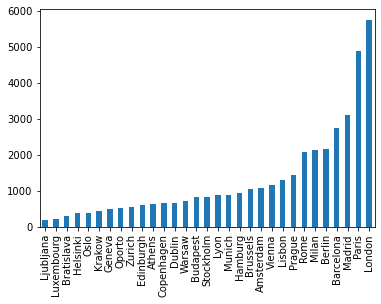

In [782]:
# Plot all cities.

df.city.value_counts().sort_values().plot(kind = 'bar')

# Start preprocessing ranking and rating.

In [783]:
# Check lengths.

df[['ranking', 'rating', 'number_reviews']].isna().value_counts()

ranking  rating  number_reviews
False    False   False             37457
                 True               2543
dtype: int64

In [784]:
df['number_reviews'].fillna(33, inplace = True) #fill with median value.

In [785]:
# MinMax normalize ranking, and number_reviews.
# Number reviews can be normalized as well.

scaler = MinMaxScaler()
df["ranking"] = scaler.fit_transform(df[["ranking"]])
#df["rating"] = scaler.fit_transform(df[["rating"]])
df["number_reviews"] = scaler.fit_transform(df[["number_reviews"]])

df.head(4)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_reviews,reviews
0,5569,Paris,"['European', 'French', 'International']",0.338685,3.5,$$ - $$$,0.019880,"[['Good food at your doorstep', 'A good hotel ..."
1,1535,Stockholm,NaN,0.093414,4.0,NaN,0.000828,"[['Unique cuisine', 'Delicious Nepalese food']..."
2,352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",0.021407,4.5,$$$$,0.071029,"[['Catch up with friends', 'Not exceptional'],..."
3,3456,Berlin,NaN,0.210241,5.0,NaN,0.000104,"[[], []]"


<AxesSubplot:>

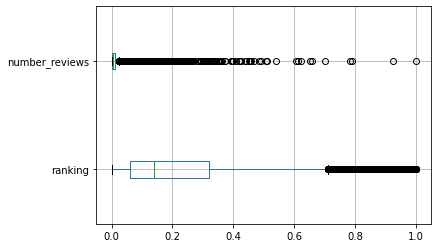

In [788]:
# There are outliers in "ranking" and "rating". Remove outliers since they are only a small portion of data.
# However, we keep number_reviews as it is.

df.boxplot(column=["ranking", "number_reviews"], vert=False)



<AxesSubplot:>

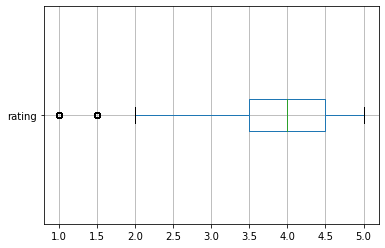

In [789]:
df.boxplot(column=["rating"], vert=False)

In [790]:
Q1_rating = df['rating'].quantile(0.25)
Q3_rating = df['rating'].quantile(0.75)
IQR_rating = Q3_rating - Q1_rating
print(IQR_rating)

Q1_ranking = df['ranking'].quantile(0.25)
Q3_ranking = df['ranking'].quantile(0.75)
IQR_ranking = Q3_ranking - Q1_ranking
print(IQR_ranking)

1.0
0.2607188469257435


In [791]:
df_out = df[~((df['ranking'] < (
    Q1_ranking - 1.5 * IQR_ranking)) | (df['ranking'] > (Q3_ranking + 1.5 * IQR_ranking)))]

df_out = df_out[~((df_out['rating'] < (
    Q1_rating - 1.5 * IQR_rating)) | (df_out['rating'] > (Q3_rating + 1.5 * IQR_rating)))]

In [792]:
# Make new feature from normalized values.

df_out['ranking_rating'] = df_out['ranking']*df_out['rating']

In [793]:
# Check the number of removed lines. Database after removing the outliers

print(len(df)-len(df_out))
df_out.head(3)

2680


,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_reviews,reviews,ranking_rating
0,5569,Paris,"['European', 'French', 'International']",0.338685,3.5,$$ - $$$,0.019880,"[['Good food at your doorstep', 'A good hotel ...",1.185398
1,1535,Stockholm,NaN,0.093414,4.0,NaN,0.000828,"[['Unique cuisine', 'Delicious Nepalese food']...",0.373654
2,352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",0.021407,4.5,$$$$,0.071029,"[['Catch up with friends', 'Not exceptional'],...",0.096333


# End preprocessin granking and rating.

In [794]:
# Find how many entries have the same restaurant_id. Assign each restaurant with a new feature 'rest_series'.

rest_count = df_out['restaurant_id'].value_counts()
rest_count_df = rest_count.reset_index()
rest_count_df.columns = ['restaurant_id', 'rest_series']

joined_df = rest_count_df.merge(df_out, on='restaurant_id', how='right')
joined_df["rest_series"] = scaler.fit_transform(joined_df[["rest_series"]])

joined_df.head(3)

,restaurant_id,rest_series,city,cuisine_style,ranking,rating,price_range,number_reviews,reviews,ranking_rating
0,5569,0.117647,Paris,"['European', 'French', 'International']",0.338685,3.5,$$ - $$$,0.019880,"[['Good food at your doorstep', 'A good hotel ...",1.185398
1,1535,0.529412,Stockholm,NaN,0.093414,4.0,NaN,0.000828,"[['Unique cuisine', 'Delicious Nepalese food']...",0.373654
2,352,0.411765,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",0.021407,4.5,$$$$,0.071029,"[['Catch up with friends', 'Not exceptional'],...",0.096333


# Start working with review date.

In [795]:
# Make separate column for 'review_date'.

joined_df['reviews'] = joined_df['reviews'].str.replace(
    '[', '', regex=True).str.replace(']', '', regex=True).str.replace("'", '', regex=True)
joined_df['reviews'] = joined_df['reviews'].apply(
    lambda s: '10/10/2017, 10/10/2017' if s == ', ' else s)
joined_df['review_date'] = joined_df['reviews'].apply(
    lambda s: re.findall(r'\d+/\d+/\d+', s))
joined_df['review_date'].apply(lambda s: len(s)).value_counts()

2    33168
1     4151
3        1
Name: review_date, dtype: int64

In [796]:
# Make dataframe with review dates.

joined_df['review_date'] = joined_df['review_date'].apply(
    lambda x: sorted([pd.to_datetime(i).date() for i in x]))

review_date_df = joined_df['review_date'].apply(pd.Series)
review_date_df.columns = ['first', 'second', 'third']

# Drop third review date as most likely irrelevant.
review_date_df.drop('third', axis=1, inplace=True)

In [797]:
review_date_df.head()

print(len(review_date_df))

print(review_date_df[['first', 'second']].max())

37320
first    2018-02-26
dtype: object


In [798]:
# Find number of days between two reviews.

review_date_df['number_days'] = (
    review_date_df['second'] - review_date_df['first']).dt.days

review_date_df['number_days'].max()

3207.0

In [799]:
# This dataset gives .median() = 40, .mean() = 113, .min() = 0.
#review_date_df['number_days'].replace(0, np.NaN)
#review_date_df['number_days'].mean()

In [800]:
# Find normalized interval between two reviews and weight it with 'rating' column

review_date_df['number_days'] = review_date_df['number_days'].replace(0, 113)
review_date_df['number_days'] = review_date_df['number_days'].replace(
    np.NaN, 113)

review_date_df['number_days'] = review_date_df['number_days'].astype(int)
review_date_df["number_days"] = scaler.fit_transform(
    review_date_df[["number_days"]])
#review_date_df['number_days'] = review_date_df['number_days'].div(3207)

review_date_df['number_days_weighted'] = review_date_df['number_days'] * \
    joined_df['rating'].round(3)

review_date_df.head(5)

,first,second,number_days,number_days_weighted
0,2017-11-20,2017-12-31,0.012477,0.043668
1,2016-06-19,2017-07-06,0.118840,0.475359
2,2018-01-06,2018-01-08,0.000312,0.001404
3,2017-10-10,2017-10-10,0.034934,0.174672
4,2017-02-19,2017-11-18,0.084529,0.338116


In [801]:
review_date_df = review_date_df.drop(
    ['first', 'second', 'number_days'], axis=1)
review_date_df.head(3)

,number_days_weighted
0,0.043668
1,0.475359
2,0.001404


# End working with review date.

In [802]:
joined_df = pd.concat([review_date_df, joined_df], axis=1)
print(len(joined_df))
joined_df.head(3)

37320


,number_days_weighted,restaurant_id,rest_series,city,cuisine_style,ranking,rating,price_range,number_reviews,reviews,ranking_rating,review_date
0,0.043668,5569,0.117647,Paris,"['European', 'French', 'International']",0.338685,3.5,$$ - $$$,0.019880,"Good food at your doorstep, A good hotel resta...",1.185398,"[2017-11-20, 2017-12-31]"
1,0.475359,1535,0.529412,Stockholm,NaN,0.093414,4.0,NaN,0.000828,"Unique cuisine, Delicious Nepalese food, 07/06...",0.373654,"[2016-06-19, 2017-07-06]"
2,0.001404,352,0.411765,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",0.021407,4.5,$$$$,0.071029,"Catch up with friends, Not exceptional, 01/08/...",0.096333,"[2018-01-06, 2018-01-08]"


In [803]:
# Replace missing values in "price_range" with a mean value 1.21.

joined_df['price_range'] = joined_df['price_range'].mask(
    joined_df['price_range'].isna(), 1.21)
joined_df['price_range'] = joined_df['price_range'].replace('$', '1').replace(
    "$$ - $$$", "2").replace("$$$$", "3").astype(float)
joined_df.price_range.value_counts()

2.00    17601
1.21    12404
1.00     5939
3.00     1376
Name: price_range, dtype: int64

In [804]:
joined_df["price_range"] = scaler.fit_transform(joined_df[["price_range"]])
joined_df.head(3)

,number_days_weighted,restaurant_id,rest_series,city,cuisine_style,ranking,rating,price_range,number_reviews,reviews,ranking_rating,review_date
0,0.043668,5569,0.117647,Paris,"['European', 'French', 'International']",0.338685,3.5,0.500,0.019880,"Good food at your doorstep, A good hotel resta...",1.185398,"[2017-11-20, 2017-12-31]"
1,0.475359,1535,0.529412,Stockholm,NaN,0.093414,4.0,0.105,0.000828,"Unique cuisine, Delicious Nepalese food, 07/06...",0.373654,"[2016-06-19, 2017-07-06]"
2,0.001404,352,0.411765,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",0.021407,4.5,1.000,0.071029,"Catch up with friends, Not exceptional, 01/08/...",0.096333,"[2018-01-06, 2018-01-08]"


In [805]:
# Explode cuisine_style to assign a dummy variable to it later.

joined_df["cuisine_style"] = joined_df.groupby(
    "city")["cuisine_style"].transform(lambda x: x.fillna(x.mode()[0]))
joined_df["cuisine_style"] = joined_df["cuisine_style"].apply(literal_eval)
joined_df1 = joined_df.explode('cuisine_style')

joined_df1.head(5)

,number_days_weighted,restaurant_id,rest_series,city,cuisine_style,ranking,rating,price_range,number_reviews,reviews,ranking_rating,review_date
0,0.043668,5569,0.117647,Paris,European,0.338685,3.5,0.500,0.019880,"Good food at your doorstep, A good hotel resta...",1.185398,"[2017-11-20, 2017-12-31]"
0,0.043668,5569,0.117647,Paris,French,0.338685,3.5,0.500,0.019880,"Good food at your doorstep, A good hotel resta...",1.185398,"[2017-11-20, 2017-12-31]"
0,0.043668,5569,0.117647,Paris,International,0.338685,3.5,0.500,0.019880,"Good food at your doorstep, A good hotel resta...",1.185398,"[2017-11-20, 2017-12-31]"
1,0.475359,1535,0.529412,Stockholm,European,0.093414,4.0,0.105,0.000828,"Unique cuisine, Delicious Nepalese food, 07/06...",0.373654,"[2016-06-19, 2017-07-06]"
1,0.475359,1535,0.529412,Stockholm,Swedish,0.093414,4.0,0.105,0.000828,"Unique cuisine, Delicious Nepalese food, 07/06...",0.373654,"[2016-06-19, 2017-07-06]"


<AxesSubplot:>

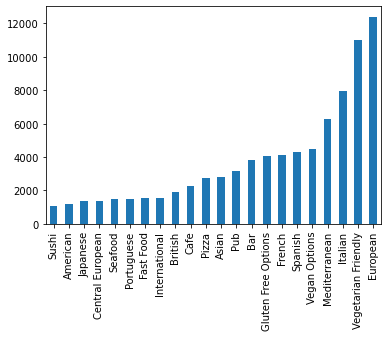

In [806]:
# Check to Cousines
s = joined_df1.cuisine_style.value_counts()
s.loc[s>1000].sort_values().plot(kind = 'bar')

In [807]:
#joined_df1['number_of_cuisines'] = joined_df1['cuisine_style'].apply(len)
######joined_df1 = joined_df1.drop(['reviews', 'review_date'], axis=1)

In [808]:
# Define dummy variables.

joined_df1 = pd.get_dummies(
    joined_df1, columns=['city', 'cuisine_style'], dummy_na=True)

joined_df1.head(5)

,number_days_weighted,restaurant_id,rest_series,ranking,rating,price_range,number_reviews,reviews,ranking_rating,review_date,...,cuisine_style_Uzbek,cuisine_style_Vegan Options,cuisine_style_Vegetarian Friendly,cuisine_style_Venezuelan,cuisine_style_Vietnamese,cuisine_style_Welsh,cuisine_style_Wine Bar,cuisine_style_Xinjiang,cuisine_style_Yunnan,cuisine_style_nan
0,0.043668,5569,0.117647,0.338685,3.5,0.500,0.019880,"Good food at your doorstep, A good hotel resta...",1.185398,"[2017-11-20, 2017-12-31]",...,0,0,0,0,0,0,0,0,0,0
0,0.043668,5569,0.117647,0.338685,3.5,0.500,0.019880,"Good food at your doorstep, A good hotel resta...",1.185398,"[2017-11-20, 2017-12-31]",...,0,0,0,0,0,0,0,0,0,0
0,0.043668,5569,0.117647,0.338685,3.5,0.500,0.019880,"Good food at your doorstep, A good hotel resta...",1.185398,"[2017-11-20, 2017-12-31]",...,0,0,0,0,0,0,0,0,0,0
1,0.475359,1535,0.529412,0.093414,4.0,0.105,0.000828,"Unique cuisine, Delicious Nepalese food, 07/06...",0.373654,"[2016-06-19, 2017-07-06]",...,0,0,0,0,0,0,0,0,0,0
1,0.475359,1535,0.529412,0.093414,4.0,0.105,0.000828,"Unique cuisine, Delicious Nepalese food, 07/06...",0.373654,"[2016-06-19, 2017-07-06]",...,0,0,0,0,0,0,0,0,0,0


In [809]:
# Drop reviews and review_date.
#joined_df1['number_reviews'].fillna(1, inplace = True)

joined_df1 = joined_df1.drop(['reviews', 'review_date'], axis=1)

joined_df1

,number_days_weighted,restaurant_id,rest_series,ranking,rating,price_range,number_reviews,ranking_rating,city_Amsterdam,city_Athens,...,cuisine_style_Uzbek,cuisine_style_Vegan Options,cuisine_style_Vegetarian Friendly,cuisine_style_Venezuelan,cuisine_style_Vietnamese,cuisine_style_Welsh,cuisine_style_Wine Bar,cuisine_style_Xinjiang,cuisine_style_Yunnan,cuisine_style_nan
0,0.043668,5569,0.117647,0.338685,3.5,0.500,0.019880,1.185398,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.043668,5569,0.117647,0.338685,3.5,0.500,0.019880,1.185398,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.043668,5569,0.117647,0.338685,3.5,0.500,0.019880,1.185398,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.475359,1535,0.529412,0.093414,4.0,0.105,0.000828,0.373654,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.475359,1535,0.529412,0.093414,4.0,0.105,0.000828,0.373654,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37318,0.027449,640,0.411765,0.038922,4.0,0.500,0.007041,0.155689,0,0,...,0,0,0,0,0,0,0,0,0,0
37318,0.027449,640,0.411765,0.038922,4.0,0.500,0.007041,0.155689,0,0,...,0,0,0,0,0,0,0,0,0,0
37318,0.027449,640,0.411765,0.038922,4.0,0.500,0.007041,0.155689,0,0,...,0,0,0,0,0,0,0,0,0,0
37318,0.027449,640,0.411765,0.038922,4.0,0.500,0.007041,0.155689,0,0,...,0,0,1,0,0,0,0,0,0,0


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [810]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = joined_df1.drop(['restaurant_id', 'rating'], axis = 1)
y = joined_df1['rating']

In [811]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [812]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [813]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [814]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [815]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.008770683763965111
